In [1]:
# Plot Q matrix on a nice map:
import numpy as np
import pickle
from build_database import flux_obj
from scipy import interpolate
from matplotlib import pyplot as plt
from GLD_file_tools import GLD_file_tools
from satellite import Satellite
import datetime
import ephem
from coordinate_structure import coordinate_structure
from coordinate_structure import transform_coords
from longitude_scaling import longitude_scaling
from ionoAbsorp import ionoAbsorp
import os
from mpl_toolkits.basemap import Basemap
from precip_model import precip_model
import itertools
from measurement_model import measurement_model
import random
import matplotlib.tri as mtri
import matplotlib as mpl


%matplotlib inline


# --------------- Latex Plot Beautification --------------------------
fig_width_pt = 650.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 16,
          'font.size': 16,
          'legend.fontsize': 16,
          'xtick.labelsize': 12,
          'ytick.labelsize': 12,
          'text.usetex': False,
          'figure.figsize': fig_size,
          'figure.autolayout': False,
          'figure.subplot.left': 0.15}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------

In [2]:
# Generator objects
GLD_root = '/Users/austin/FUSE2/shared/users/asousa/WIPP/fluxMDP/GLD'

sat_TLE  = ["1 40378U 15003C   15293.75287141  .00010129  00000-0  48835-3 0  9990",
            "2 40378  99.1043 350.5299 0153633 201.4233 158.0516 15.09095095 39471"]

gld = GLD_file_tools(GLD_root,prefix='GLD')

# Satellite object:
sat = Satellite(sat_TLE[0], sat_TLE[1],'Firebird 4')

# Measurement object:
f = measurement_model(database = 'database_dicts.pkl', GLD_root=GLD_root, multiple_bands = True)

p = precip_model(database = 'database_dicts.pkl',multiple_bands=False)

bands = dict()
bands['low'] = [1,2]
bands['mid'] = [3, 4, 5]
bands['high']= [6, 7, 8]

# Column ind
lat_ind = 7;
lon_ind = 8;
mag_ind = 9;

In [3]:
plottime = datetime.datetime(2015,11, 1,0,45,0)
td = datetime.timedelta(seconds=10)

# sampling grid (geomagnetic)
grid_lons = np.linspace(-180,180,360)
grid_lats = np.linspace( 0, 65, 65)
grid_time = np.linspace(-1*td.seconds,0,td.seconds)

# Get flashes within timeframe:

flashes, flash_times = gld.load_flashes(plottime, td)
flashes = flashes[:,(lat_ind, lon_ind, mag_ind, mag_ind)]
geo_flashes = flashes
flash_coords = transform_coords(flashes[:,0], flashes[:,1], np.zeros_like(flashes[:,0]), 'geographic', 'geomagnetic')
flashes[:,:2] = flash_coords[:,:2]
flashes[:,3] = [(plottime - s).microseconds*1e-6 + (plottime - s).seconds for s in flash_times]


print np.shape(flashes)
sat.compute(plottime)
sat.coords.transform_to('geomagnetic')


#print grid_time
N_grid = np.zeros([np.size(grid_lons), np.size(grid_lats), np.size(grid_time)])
S_grid = np.zeros([np.size(grid_lons), np.size(grid_lats), np.size(grid_time)])

N_tmp_lat_time = np.zeros([np.size(grid_lats), np.size(grid_time)])
S_tmp_lat_time = np.zeros([np.size(grid_lats), np.size(grid_time)])



for in_coord in flashes: #masked_flashes:
    input_lat = in_coord[0]
    input_lon = in_coord[1]
    input_mag = in_coord[2]
    input_tim = in_coord[3]
    
    #print "input coords: ", input_lat, input_lon, input_mag, input_tim
    #print "Start time: ", grid_time[0] + input_tim
    for ind_lat, lat in enumerate(grid_lats):

        # Northern hemisphere incident flash
        N_tmp_lat_time[ind_lat,:] = p.get_precip_at(input_lat, lat, grid_time + input_tim)
        S_tmp_lat_time[ind_lat,:] = p.get_precip_at(input_lat, -1.0*lat, grid_time + input_tim)
                       
        ls = p.get_longitude_scaling(input_lat, input_lon, grid_lons, I0=input_mag)

        N_grid[:,ind_lat,:] += np.outer(ls,N_tmp_lat_time[ind_lat,:])
        S_grid[:,ind_lat,:] += np.outer(ls,S_tmp_lat_time[ind_lat,:])
        
        #print np.sum(np.isnan(N_grid))
        #print np.sum(np.isnan(S_grid))
#plt.close()

(489, 4)


/Users/austin/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log10
/Users/austin/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10


[ 6.541651  6.536858  6.499338  6.495266  6.482639  6.463113  6.412249
  6.391443  6.356754  6.335846  6.302285  6.298813  6.295896  6.254401
  6.248944  6.245423  6.221749  6.19876   6.162391  6.103641  6.076805
  6.050283  5.994558  5.92337   5.881874  5.849726  5.839357  5.837191
  5.813692  5.780991  5.770181  5.732065  5.725831  5.706067  5.695533
  5.694287  5.663011  5.655888  5.647366  5.638979  5.634249  5.624124
  5.612724  5.605299  5.588866  5.573794  5.57002   5.561604  5.559966]


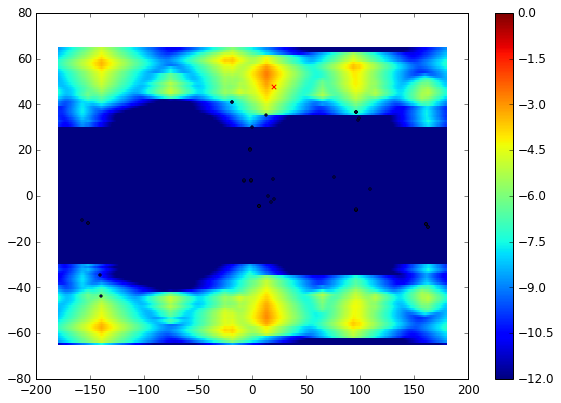

In [5]:
tt=4
f,ax = plt.subplots(1,1)
tmask = (flashes[:,3] + grid_time[tt] > 0 ) & (flashes[:,3] + grid_time[tt] < 1)
print flashes[tmask,3]
plt.pcolor(grid_lons,  grid_lats, np.log10(N_grid[:,:,tt].T))
plt.clim([-12,0])
plt.pcolor(grid_lons, -1*np.flipud(grid_lats), np.fliplr(np.log10(S_grid[:,:,tt])).T)
plt.clim([-12,0])
plt.colorbar()
plt.scatter(flashes[tmask,1], flashes[tmask,0],marker='.')
plt.scatter(sat.coords.lon(), sat.coords.lat(),marker='x',color='red')
#plt.scatter(masked_coords.lon(), masked_coords.lat())
#plt.clim([-12,0])
plt.show() 


/Users/austin/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in log10
/Users/austin/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:37: RuntimeWarning: divide by zero encountered in log10


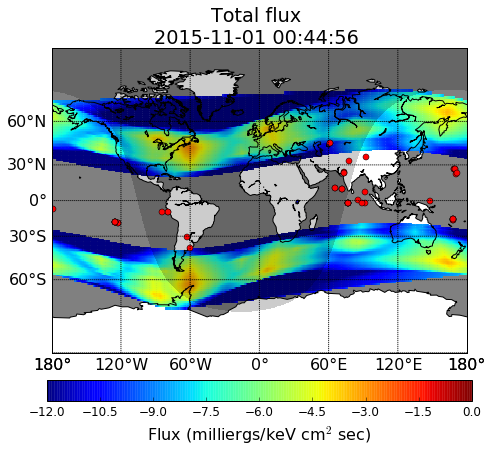

In [8]:
# Grid up geographic coordinates (once we transform from geomagnetic, we won't be on a regular grid)

geo_lats = np.empty([len(grid_lons), len(grid_lats)])
geo_lons = np.empty([len(grid_lons), len(grid_lats)])
geo_lats_s = np.empty([len(grid_lons), len(grid_lats)])


for lo_ind, lo in enumerate(grid_lons):
    for la_ind, la in enumerate(grid_lats):
        temp_coords = coordinate_structure(la, lo, 400, 'geomagnetic')
        temp_coords.transform_to('geographic')
        geo_lats[lo_ind, la_ind] = temp_coords.lat()[0]
        geo_lons[lo_ind, la_ind] = temp_coords.lon()[0]

        # Repeat for southern hemisphere
for lo_ind, lo in enumerate(grid_lons):
    for la_ind, la in enumerate(grid_lats):
        temp_coords = coordinate_structure(-1*la, lo, 400, 'geomagnetic')
        temp_coords.transform_to('geographic')
        geo_lats_s[lo_ind, la_ind] = temp_coords.lat()[0]


        
        
# Next, re-interpolate data onto a regular grid in geographic (basemap isn't happy with nonuniform)
rlons, rlats = np.meshgrid(np.linspace(-180,180,360), np.linspace(-90,90,180))
clims = [-12,0]

# print np.shape(rlons)
# print np.shape(rlats)
# print np.shape(N_grid)

tli_N = mtri.LinearTriInterpolator(mtri.Triangulation(geo_lons.flatten(), geo_lats.flatten()),
                                 np.log10(N_grid[:,:,tt]).flatten())

tli_S = mtri.LinearTriInterpolator(mtri.Triangulation(geo_lons.flatten(), geo_lats_s.flatten()),
                                 np.log10(S_grid[:,:,tt]).flatten())

rndata = tli_N(rlons, rlats)
rsdata = tli_S(rlons, rlats)


f, ax = plt.subplots(1,1)
m = Basemap(projection='mill',lon_0=0,ax=ax)

# Geographic flashes (masked for time. This is ugly, sorry)
geo_flashes = transform_coords(flashes[tmask,0], flashes[tmask,1], np.zeros_like(flashes[tmask,0]),
                               'geographic', 'geomagnetic')
x,y = m(geo_flashes[:,1],geo_flashes[:,0])
PTS= m.plot(x,y,'ro',ax=ax)[0]


m.drawcoastlines(color='k',linewidth=1,ax=ax)
m.drawparallels(np.arange(-90,90,30),labels=[1,0,0,0])
m.drawmeridians(np.arange(m.lonmin,m.lonmax+30,60),labels=[0,0,0,1])
m.drawmapboundary(fill_color='grey')
m.fillcontinents(color='white',lake_color='b',zorder=0)
NM = m.pcolormesh(rlons, rlats, rndata ,latlon=True,alpha=0.9,ax=ax, vmin=clims[0],vmax=clims[1])
SM = m.pcolormesh(rlons, rlats,rsdata,latlon=True,alpha=0.9,ax=ax, vmin=clims[0],vmax=clims[1])

plt.colorbar(mappable=NM,label="Flux (milliergs/keV cm$^2$ sec)",ax=ax,orientation='horizontal',shrink=0.62,pad=0.07) # draw colorbar


CS=m.nightshade(plottime,alpha=0.2)
ax.set_title('Total flux \n%s '% (plottime - datetime.timedelta(seconds=tt)))
#cax,kw = mpl.colorbar.make_axes(ax)
plt.tight_layout()


figname = 'sweet_map%s.png'%plottime.isoformat()
plt.savefig(figname,dpi=300,bbox_inches='tight')

6372.795
(360,)
(360,)
3.22709577801
2223.88897429
-0.0387251493362
-26.6866676915


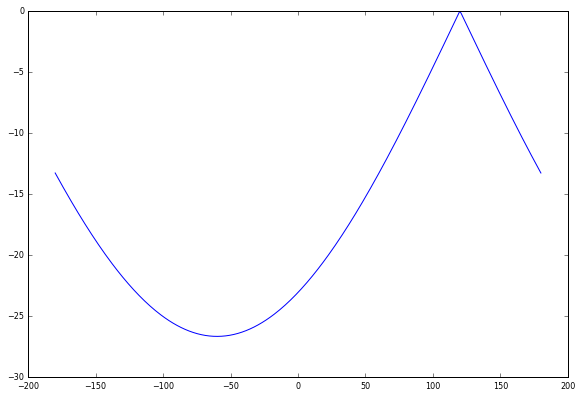

In [6]:
import geopy.distance

print geopy.distance.EARTH_RADIUS

inp_lat = 80
inp_lon = 120
out_lon = grid_lons
d2r = np.pi/180.0
R_earth = 6371
path_atten = -12.0
b = np.cos(d2r*inp_lat)*np.sin(d2r*(inp_lon - out_lon)/2.0)
dist_lon = R_earth*2*np.arcsin(np.abs(b))





vals = dist_lon*path_atten/1000.0
tmp = np.power(10,vals.flatten()/10.0)
tmp = vals.flatten()
print np.shape(vals)
print np.shape(grid_lons)
#tmp = p.get_longitude_scaling(0,179,grid_lons)
plt.plot(grid_lons, tmp)
print np.min(dist_lon)
print np.max(dist_lon)

print np.max(tmp)
print np.min(tmp)

11917

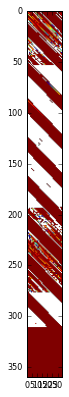

In [17]:
tmp = (S_grid[::-1,::-1,tt])

plt.imshow(tmp)

np.sum(np.isnan(N_grid))